In [2]:
import torch 
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)


In [3]:
with open('input_tiny.txt','r',encoding='utf-8') as f: # with statement replaces a try-catch block with a concise shorthand
    # ensures closing resources right after processing them.
    text=f.read()
print(f"length of the dataset characters {len(text)}")

length of the dataset characters 1115393


In [4]:
# pick out the unique characters
chars=sorted(list(set(text)))
vocab_size=len(chars)
print("".join(chars))


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [5]:
# creating mapping from char to integers
stoi={ch:i for i,ch in enumerate(chars)} # enumerate gives index(not key) value
itos={i:ch for i,ch in enumerate(chars)}
# for index_int,val in enumerate (stoi):
#     print(f"key: {val} value: {stoi[val]} ")


# lambda takes lambda var: -----> var as input to the function 
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers 
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [6]:
import torch 
data= torch.tensor(encode(text), dtype=torch.long)
print(data.shape)
print(data[:10])
# print(decode(data[0][:10].item()))


torch.Size([1115393])
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47])


In [7]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

def tensor_decoder(ten):
    dec=decode([ten[x].item() for x in range(ten.shape[0])])
    return dec
    

# dec=[data[x].item() for x in range(10)]
# decode(dec)

In [8]:
block_size = 8 # also called the context size
train_data[:block_size+1] # +1 because if lets say abcd, the len is 3, d context is abc 


# context can be taken anywhere between 1 to 8 is the meaning

x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


In [9]:
# print(len(data))
batch_size=4
# print(torch.randint(len(data) - block_size, (batch_size,)))
ix = torch.randint(len(data) - block_size, (batch_size,))
# print(ix)
print([data[i:i+block_size] for i in ix]) # block size is 8

[tensor([56, 43, 40, 43, 50,  0, 13, 52]), tensor([39, 45, 43,  8,  0,  0, 31, 43]), tensor([42,  6,  1, 42, 43, 41, 50, 47]), tensor([50,  1, 58, 46, 56, 53, 52, 43])]


In [10]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?-> yes
block_size = 8 # what is the maximum context length for predictions?-> yes

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,)) # catches starting point randomly from any line
    x = torch.stack([data[i:i+block_size] for i in ix])   ## they become a row in 4x8 tensor
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs(xb):')
print(xb.shape)
print(xb)
print('targets(yb):')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")
        
        
### Done

inputs(xb):
torch.Size([4, 8])
tensor([[53, 59,  6,  1, 58, 56, 47, 40],
        [49, 43, 43, 54,  1, 47, 58,  1],
        [13, 52, 45, 43, 50, 53,  8,  0],
        [ 1, 39,  1, 46, 53, 59, 57, 43]])
targets(yb):
torch.Size([4, 8])
tensor([[59,  6,  1, 58, 56, 47, 40, 59],
        [43, 43, 54,  1, 47, 58,  1, 58],
        [52, 45, 43, 50, 53,  8,  0, 26],
        [39,  1, 46, 53, 59, 57, 43,  0]])
----
when input is [53] the target: 59
when input is [53, 59] the target: 6
when input is [53, 59, 6] the target: 1
when input is [53, 59, 6, 1] the target: 58
when input is [53, 59, 6, 1, 58] the target: 56
when input is [53, 59, 6, 1, 58, 56] the target: 47
when input is [53, 59, 6, 1, 58, 56, 47] the target: 40
when input is [53, 59, 6, 1, 58, 56, 47, 40] the target: 59
when input is [49] the target: 43
when input is [49, 43] the target: 43
when input is [49, 43, 43] the target: 54
when input is [49, 43, 43, 54] the target: 1
when input is [49, 43, 43, 54, 1] the target: 47
when input is [

In [11]:
# x = torch.randn(1, 3)
# x.shape
# torch.stack((x,x)).shape
# >>> torch.stack((x, x)) # same as torch.stack((x, x), dim=0)
# tensor([[[ 0.3367,  0.1288,  0.2345],
#          [ 0.2303, -1.1229, -0.1863]],

#         [[ 0.3367,  0.1288,  0.2345],
#          [ 0.2303, -1.1229, -0.1863]]])
# >>> torch.stack((x, x)).size()
# torch.Size([2, 2, 3])
# >>> torch.stack((x, x), dim=1)
# tensor([[[ 0.3367,  0.1288,  0.2345],
#          [ 0.3367,  0.1288,  0.2345]],

#         [[ 0.2303, -1.1229, -0.1863],
#          [ 0.2303, -1.1229, -0.1863]]])
# >>> torch.stack((x, x), dim=2)
# tensor([[[ 0.3367,  0.3367],
#          [ 0.1288,  0.1288],
#          [ 0.2345,  0.2345]],

#         [[ 0.2303,  0.2303],
#          [-1.1229, -1.1229],
#          [-0.1863, -0.1863]]])
# >>> torch.stack((x, x), dim=-1)
# tensor([[[ 0.3367,  0.3367],
#          [ 0.1288,  0.1288],
#          [ 0.2345,  0.2345]],

#         [[ 0.2303,  0.2303],
#          [-1.1229, -1.1229],
#          [-0.1863, -0.1863]]])

In [12]:
class BigramLanguageModel(nn.Module):
    def __init__(self,vocab_size):
        super().__init__() # inherit everything from nn class
        embd_dim=vocab_size
        self.token_embedding_table=nn.Embedding(vocab_size,embd_dim) # token embeding table of size vocab_size*vocab_size
        # why vocab size x vocab size why not just vocab size x anything
    #     def show_embedding(self):
    #         print(self.token_embedding_table)
    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        # why input as BxC
        logits = self.token_embedding_table(idx) # (B,T,C) every idx pluck correspoinding row from embedding table
        # how is this giving the output as logits--> what does logits look like
        # How will the embedding table look like # B batch=4, T time is 8 and C channel is vocab size(65 in this case)
        # Pluck out the rows, arrange them in B, T, C
        # logits are the score for the next in the sequence 
        # Still confused about what is channel- > has to do with embedding

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape # C is the embedding dimension
#             print("from inside the class")
#             print(f"B {B}\nT: {T}\nC: {C}\n")
            logits = logits.view(B*T, C) # see the documentation --> most likely flatten portion
            targets = targets.view(B*T) # alternatively can do -1 
            loss = F.cross_entropy(logits, targets) #--> how is this working and what about C 
            # log(p) where p is the probability of the target
            # okay clear
        return logits, loss

    def generate(self, idx, max_new_tokens): # take in context and generate +1+2 upto max tokens
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx) # work os forward ??
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C) # because bigram
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)?
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx




In [13]:
m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb) ## how do we know it is going to forward 
# --> why is it going to forward by default 
print(logits.shape) # logits is 32x64 because (B*TxC)
print(loss)
# b,t,c=logits.shape
# print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

torch.Size([32, 65])
tensor(4.9456, grad_fn=<NllLossBackward0>)


In [14]:
m = BigramLanguageModel(vocab_size)
print(m.token_embedding_table)
print(xb.shape)

Embedding(65, 65)
torch.Size([4, 8])


In [15]:
optimizer=torch.optim.AdamW(m.parameters(),lr=1e-3)

In [16]:
batch_size=32 # this is used in get_batch--> output should be 32*8
for steps in range(1000):
    xb,yb= get_batch('train')
    
    logits, loss=m(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward() # meaning
    optimizer.step() # meaning
    
print(loss.item())

3.668074131011963


In [17]:
import math
math.log(1/65)

-4.174387269895637

### Maths Self Attantion

In [18]:
## Evertyhing from the above code is almost clear now--> atleast the tensor size part.

torch.manual_seed(1337)
B,T,C = 4,8,32
x=torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 32])

Self attention pseudo example (querry, key, value)

In [19]:
import numpy as np
class Node:
    def __init__(self):
        
        # the vector stores at this node
        self.data=np.random.randn(20) 
        
        # weights governing how this node interacts with other nodes
        self.wkey= np.random.randn(20,20)
        self.wquery= np.random.randn(20,20)
        self.wvalue= np.random.randn(20,20)
        
        
    def key(self):
        # what do i have ?
        return self.wkey@self.data # why self@data
    
    def query(self):
        # what am i looking for ?
        return self.wquery@self.data # why self@data
    def value(self):
        # what do i publicly reveal or broadcast to others ?
        return self.wvalue@self.data # why self@data



class Graph:
    def __init__(self):
        # make 10 nodes
        self.nodes=[Node() for _ in range(10)]
        
        # make 40 edges
        randi=lambda: np.random.randint(len(self.nodes))
        self.edges=[[randi(),randi()] for _ in range(40)] # does it include self node aswell
        
    def run(self):
        updates=[]
        for i, n in enumerate (self.nodes): # i,n --> integer value
            
            # what is this node looking for?
            q=n.query() # q-> (20,1)
            
            # find all the edges that are input to this node
            inputs=[self.nodes[ifrom] for (ifrom,ito) in self.edges if ito==i]
            
            if len(inputs)==0:
                continue # ignore
            # gather their keys, i.e. what they hold
            keys=[m.keys() for m in inputs]
            
            # calculate the compatibilities
            
            scores= [k.dot(q) for k in keys]    # scaler
            # softmax them so they sum to 1
       
            scores=np.exp(scores)
            scores= scores/np.sum(scores) # normalized scores scaler
            # gahter the appropriate values with a weighted sum
            values= [m.value() for m in inputs]
            update=sum([s*v for s,v in zip(scores,values)])
            updates.append(update)
            
            
            
        for n,u in zip(self.nodes, updates):
            n.data=n.data+u # residual connection
            
                
            

In [20]:
# token talking is to summarize the interaction-- very lossy communication
# 

# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float() # between 0 to 10 with size 3x2
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)
# communciation step

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [21]:
a = torch.tril(torch.ones(3, 3))
torch.sum(a, 1, keepdim=True)

tensor([[1.],
        [2.],
        [3.]])

In [22]:
# each token contain a querry and a key vector--> querry vector is what am i looking for, key vector is what do i contain
# my querry dot product with all the keys--> that dot product becomes wei(which was earlier just the average)

In [23]:
import torch
# Create a tensor
tensor = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
print(tensor.shape)
# Calculate the mean of all elements in the tensor
mean_all = torch.mean(tensor)
print(f"Mean of all elements: {mean_all}")
# Calculate the mean along a specific dimension (rows)
mean_dim0 = torch.mean(tensor, dim=0)
print(f"Mean along rows (dim=0): {mean_dim0}")
# Calculate the mean along a specific dimension (columns)
mean_dim1 = torch.mean(tensor, dim=1)
print(f"Mean along columns (dim=1): {mean_dim1}")

torch.Size([2, 2])
Mean of all elements: 2.5
Mean along rows (dim=0): tensor([2., 3.])
Mean along columns (dim=1): tensor([1.5000, 3.5000])


In [24]:
torch.manual_seed(1337)
B,T,C = 4,8,2
x=torch.randn(B,T,C)
x.shape
print(x[0,1])

tensor([-0.3596, -0.9152])


In [25]:
# we want x[b,t]= mean_{i<=t} x[b,i]
xbow=torch.zeros((B,T,C)) # bow is bag of words  -> word stored at each location and we are averaging

for b in range(B):
    for t in range(T):
        xprev=x[b,:t+1] # (t,:c)
        xbow[b,t] = torch.mean(xprev,0)
# print(f"xprev: {xprev}")
# print(f"xbow: {xbow}")

# OKAY
        

In [26]:
x[0]

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])

In [27]:
xbow[0]

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

In [28]:
(0.1808-0.3596)/2

-0.0894

In [29]:
wei=torch.tril(torch.ones(T,T))
print(wei)
wei=wei/wei.sum(dim=1,keepdim=True)
print(wei)
xbow2=wei@x # (T,T) @ (B,T,C) ---> (B(created),T,T) @ (B,T,C) --> batch multiplication #Ask Manisha why is it called bag of words?
print(xbow.shape[0])
for xin in range(xbow.shape[0]):
    print(torch.allclose(xbow[xin],xbow2[xin]))#  xbow2 is same as xbow1 

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])
4
True
False
True
True


In [30]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)
torch.allclose(xbow, xbow2)

False

In [31]:
# wei = torch.tril(torch.ones(3, 3))
# wei.sum(1,keepdim=True)
# wei.sum(1,keepdim=False)
# wei.sum(0,keepdim=False)
# wei.sum(0,keepdim=True)

In [32]:
# print(xbow2[1])
# print(xbow[1])
# print(torch.allclose(xbow[1],xbow2[1]))

In [33]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)

False

In [34]:
##### Start from here ########

In [35]:
import numpy as np

class Node:
    def __init__(self):
        
        # the vector stores at this node
        self.data=np.random.randn(20) 
        
        # weights governing how this node interacts with other nodes
        self.wkey= np.random.randn(20,20)
        self.wquery= np.random.randn(20,20)
        self.wvalue= np.random.randn(20,20)
        
        
    def key(self):
        # what do i have ?
        return self.wkey@self.data # why self@data
    
    def query(self):
        # what am i looking for ?
        return self.wquery@self.data # why self@data
    def value(self):
        # what do i publicly reveal or broadcast to others ?
        return self.wvalue@self.data # why self@data




class Graph:
    def __init__(self):
        # make 10 nodes
        self.nodes=[Node() for _ in range(10)]
        
        # make 40 edges
        randi=lambda: np.random.randint(len(self.nodes))
        self.edges=[[randi(),randi()] for _ in range(40)] # does it include self node aswell
        
    def run(self):
        updates=[]
        for i, n in enumerate (self.nodes):
            
            # what is this node lookinf for?
            q=n.query()
            print(f"shape of querry is {np.array(q).shape}")
            # find all the edges that are input to this node
            inputs=[self.nodes[ifrom] for (ifrom,ito) in self.edges if ito==i]
            
            if len(inputs)==0:
                continue # ignore
            # gather their keys, i.e. what they hold
            keys=[m.key() for m in inputs]
            # k1=np.array(keys)
            # calculate the compatibilities
            
            scores= [k.dot(q) for k in keys]

   
            # softmax them so they sum to 1
            scores=np.exp(scores)
            scores= scores/np.sum(scores)
            # gahter the appropriate values with a weighted sum
            values= [m.value() for m in inputs]

            
            update=sum([s*v for s,v in zip(scores,values)])
            print(f"shape of inputs is {np.array(inputs).shape}")
            
            print(f"shape of values is {np.array(values).shape}")
            print(f"shape of keys is {np.array(keys).shape}")
            print(f"shape of score (softmat(k.dot(q))) is {np.array(scores).shape}")
            print(f"shape of update is {np.array(update).shape}")


            updates.append(update)
            
            
            
        for n,u in zip(self.nodes, updates):
            n.data=n.data+u # residual connection

            # dimension ask prajyot
        
            
            
            
            
        
        


In [36]:
t1=Graph()
t1.run()

shape of querry is (20,)
shape of inputs is (2,)
shape of values is (2, 20)
shape of keys is (2, 20)
shape of score (softmat(k.dot(q))) is (2,)
shape of update is (20,)
shape of querry is (20,)
shape of inputs is (2,)
shape of values is (2, 20)
shape of keys is (2, 20)
shape of score (softmat(k.dot(q))) is (2,)
shape of update is (20,)
shape of querry is (20,)
shape of inputs is (4,)
shape of values is (4, 20)
shape of keys is (4, 20)
shape of score (softmat(k.dot(q))) is (4,)
shape of update is (20,)
shape of querry is (20,)
shape of inputs is (3,)
shape of values is (3, 20)
shape of keys is (3, 20)
shape of score (softmat(k.dot(q))) is (3,)
shape of update is (20,)
shape of querry is (20,)
shape of inputs is (5,)
shape of values is (5, 20)
shape of keys is (5, 20)
shape of score (softmat(k.dot(q))) is (5,)
shape of update is (20,)
shape of querry is (20,)
shape of inputs is (5,)
shape of values is (5, 20)
shape of keys is (5, 20)
shape of score (softmat(k.dot(q))) is (5,)
shape of up

In [37]:
q1=torch.randn(20)
q1.shape
k_connected=torch.randn(2,20)
scores= [k.dot(q1) for k in k_connected]
scores=np.exp(scores)
scores= scores/np.sum(scores)
print(scores.shape)
values=torch.randn(2,20)
for s,v in zip (scores,values):
    print(s)
    print(v.shape)
    print(f"s*v is ({s*v})")
update=sum([s*v for s,v in zip(scores,values)])
print(f"update is {update}")


(2,)
0.0010062506
torch.Size([20])
s*v is (tensor([ 1.6320e-03,  1.0842e-03,  5.9850e-04, -1.5386e-03, -9.0166e-04,
         6.6605e-05, -5.6632e-05,  2.3559e-03, -1.0092e-04,  1.0605e-03,
        -6.2697e-04, -1.6005e-03,  4.5367e-06,  2.0602e-03, -1.5853e-04,
        -2.2004e-04, -1.0832e-03,  2.6066e-03,  4.9715e-04,  4.7009e-04]))
0.99899375
torch.Size([20])
s*v is (tensor([-0.3451, -1.1613,  0.1443,  0.1662,  1.0774, -0.6143, -0.4584,  0.5669,
         0.0958, -1.5684,  0.3736, -0.1419, -1.2411, -0.9609, -0.0849,  0.1184,
         0.1462,  0.2534,  0.2134,  0.3111]))
update is tensor([-0.3434, -1.1602,  0.1449,  0.1646,  1.0765, -0.6143, -0.4584,  0.5693,
         0.0957, -1.5673,  0.3730, -0.1435, -1.2411, -0.9588, -0.0851,  0.1182,
         0.1452,  0.2560,  0.2139,  0.3115])


In [56]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

#################

# every single token will emit querry(what i am looking for) and a key(what do i contain)
# if key and querry are aligned then we will interact more with that token

# let's see a single Head perform self-attention
head_size = 16 # hyperparameter 
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False) # difference between embedding and this thing?
value = nn.Linear(C, head_size, bias=False) # we aggregate value not tokens
# if you are interested in me, here is what i will communicatte to you--> v gets aggregate
 
# confusion is here
# (b,t,c) --> (b,t,16)
# creating key and queery
k = key(x)   # (B, T, 16) 
q = query(x) # (B, T, 16)
# wei or the affinity
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)  # transpose last two dimensions 
# do we have to give them pairs
 # bash matrix multiplication 

tril = torch.tril(torch.ones(T, T))
print(tril)
print(wei.shape)
tril2=torch.tril(torch.ones(4,4))
k=torch.rand(4,4)
kt=k.masked_fill(tril2 == 0, float('-inf'))
print(k)
print(kt)

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])
torch.Size([4, 8, 8])
tensor([[0.1245, 0.4640, 0.4816, 0.8707],
        [0.1398, 0.6107, 0.3780, 0.5809],
        [0.2623, 0.9278, 0.5112, 0.0747],
        [0.7416, 0.3508, 0.9414, 0.4156]])
tensor([[0.1245,   -inf,   -inf,   -inf],
        [0.1398, 0.6107,   -inf,   -inf],
        [0.2623, 0.9278, 0.5112,   -inf],
        [0.7416, 0.3508, 0.9414, 0.4156]])


In [39]:
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf')) # in the decoder block this will always be present, 
                                                # in the encoder block this will be asbset
wei = F.softmax(wei, dim=-1) #dimension -1 why?

v = value(x)
out = wei @ v
#out = wei @ x

out.shape

torch.Size([4, 8, 16])

In [40]:
#######################  portion from the repo  #################################

In [41]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 1000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4 # it is h in the picture
n_layer = 4
dropout = 0.0

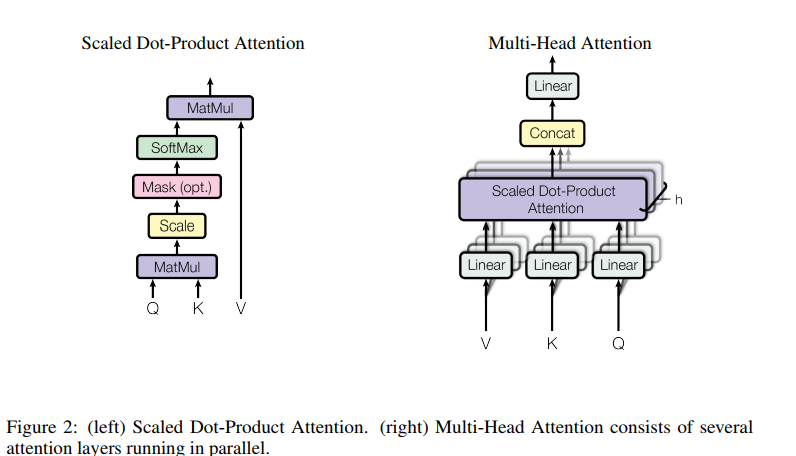

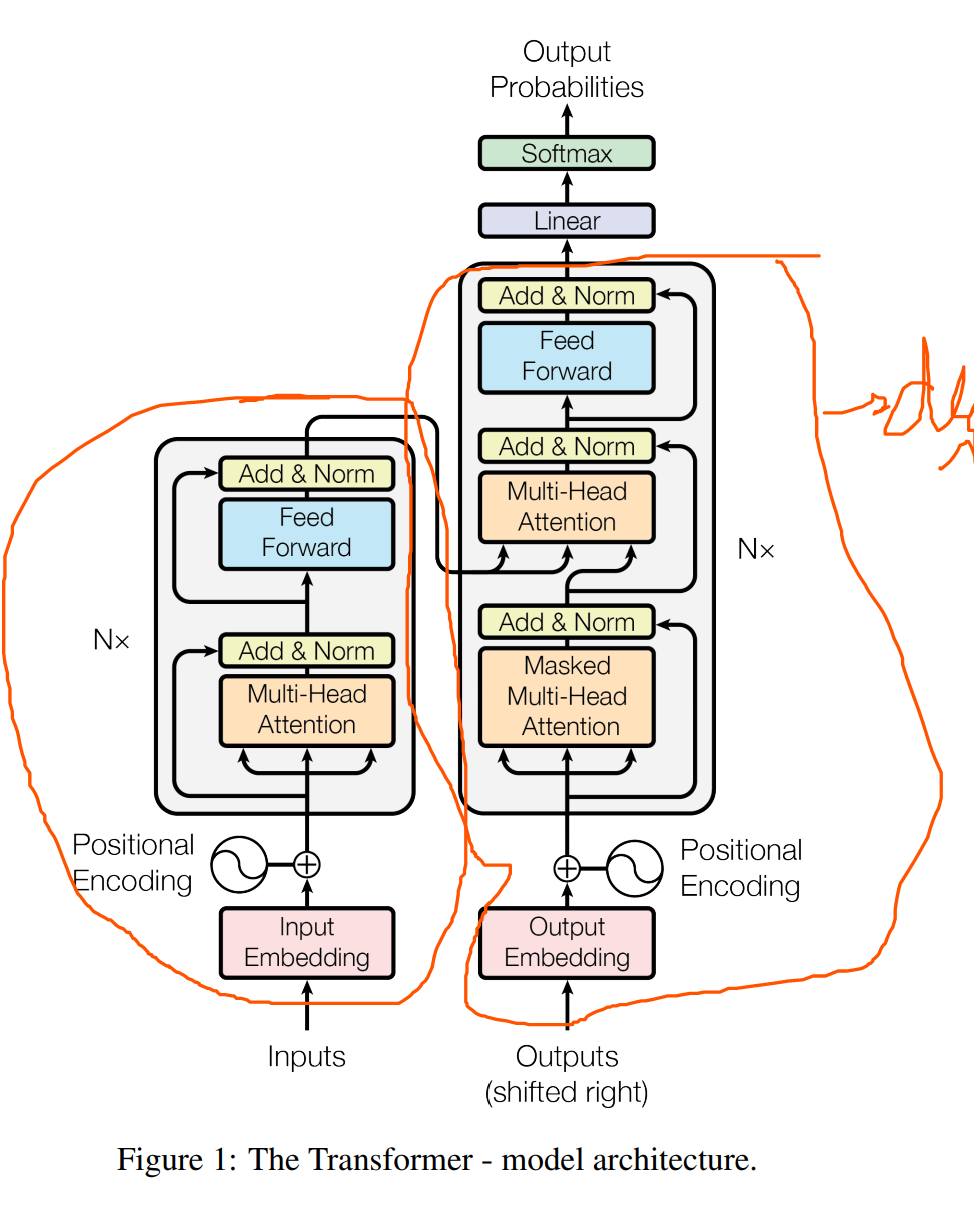

In [ ]:

with open('input_tiny.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters) #eval_iters = 200
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()# per batch losses
        out[split] = losses.mean() # after iteration loss
    model.train()
    return out

class Head(nn.Module): ###????????????
    """ one head of self-attention """ 

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        # n_embd = 64
        # n_head = 4
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size))) # why do we use register_buffer?
        # block size= 32
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape # C is embd size
        k = self.key(x)   # (B,T,C) is C is head size
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        # understood 
        return out

class MultiHeadAttention(nn.Module): ###???????????????
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)]) # ???--> h in the figure
        self.proj = nn.Linear(n_embd, n_embd) #n_embd = 64 ?? ???? still not clear
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        k=[h(x) for h in self.heads]
        # print([h(x) for h in self.heads])
        out = torch.cat([h(x) for h in self.heads], dim=-1) #### why dim 1 ### most likely b,t,c
        # print(f"multi head size {out.shape}")
        out = self.dropout(self.proj(out)) #3 ?????????? --  out.shape
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head ## 32/4=8
        self.sa = MultiHeadAttention(n_head, head_size) ## expeted b,t,c
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd) ###???
        self.ln2 = nn.LayerNorm(n_embd) ###???

    def forward(self, x):
        x = x + self.sa(self.ln1(x)) ##?? Residual
        x = x + self.ffwd(self.ln2(x)) ##???
        return x

In [43]:
#  bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # block size is context size-chaeck
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)]) #####??????
        # sequential block size ek ke baad ek
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        print(f"context is idx {idx}")
        idx_cond = idx[:, -block_size:]
        print(f"idx_cond is {idx_cond}")
        # idx is (B, T) array of indices in the current context
        
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)




0.209729 M parameters


In [44]:
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# # generate from the model
# context = torch.zeros((1, 1), dtype=torch.long, device=device)
# print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

step 0: train loss 4.3292, val loss 4.3287
step 100: train loss 2.6442, val loss 2.6464
step 200: train loss 2.5105, val loss 2.5046
step 300: train loss 2.4223, val loss 2.4414
step 400: train loss 2.3589, val loss 2.3742
step 500: train loss 2.3122, val loss 2.3292
step 600: train loss 2.2670, val loss 2.2735
step 700: train loss 2.2115, val loss 2.2330
step 800: train loss 2.1815, val loss 2.2047
step 900: train loss 2.1428, val loss 2.1796
step 999: train loss 2.0989, val loss 2.1408


In [45]:
# m = model.to(device)
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)

sten="Before we proceed any further, hear me s"
sten_encode=encode(sten)
print(len(sten_encode))


40


In [46]:
context=torch.tensor(sten_encode).view(8,-1)
print(context.shape)

torch.Size([8, 5])


In [47]:
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist())) # zero is for batch one

context is idx tensor([[14, 43, 44, 53, 56],
        [43,  1, 61, 43,  1],
        [54, 56, 53, 41, 43],
        [43, 42,  1, 39, 52],
        [63,  1, 44, 59, 56],
        [58, 46, 43, 56,  6],
        [ 1, 46, 43, 39, 56],
        [ 1, 51, 43,  1, 57]])
idx_cond is tensor([[14, 43, 44, 53, 56],
        [43,  1, 61, 43,  1],
        [54, 56, 53, 41, 43],
        [43, 42,  1, 39, 52],
        [63,  1, 44, 59, 56],
        [58, 46, 43, 56,  6],
        [ 1, 46, 43, 39, 56],
        [ 1, 51, 43,  1, 57]])
Befor,
By beat muon thee hamme e roseed.

LAKWARD RKE

YIMNENRD:
Hencar a fathan that andppas to sar, Yur
He he is sirglaid ovanot hist his crondiat seevevo stad;
O, nast stincule sor nope you thave hiM may searte e, beava efied efar
Warger thele' but hy tou ast byeasen.

UNEURK:
Lontlys i'd haven bry gie trous ofer hat,
The ning Core and wetsis hen tand
I and bon liftirng is afor wasl he,
And deealt nomer:' ritt hat arnthinf as be mande.

ARDULE:
I s
Thave feuch baken is f muspe ees so

In [48]:
###################### end decoder only ###########################################

In [49]:

############## encoder decoder ##############################       

In [50]:
###################### Step 2 and Step 3 ################

Notes:

- Attention is a \boldface{communication mechanism}. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with tril, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides wei by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

In [51]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

In [52]:
print(k.var())
print(q.var())
print(wei.var())

tensor(0.9952)
tensor(1.0246)
tensor(0.9619)


In [53]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

In [54]:
class Head(nn.Module):
    """ one head of self-attention """
    
  
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

#         self.dropout = nn.Dropout(dropout)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
#         logits = self.token_embedding_table(idx) # (B,T,C) every idx pluck correspoinding row from embedding table
        # how is this giving the output as logits--> what does logits look like
        # How will the embedding table look like # B batch=4, T time is 8 and C channel is vocab size(65 in this case)
        # Pluck out the rows, arrange them in B, T, C
        # logits are the score for the next in the sequence 
        # Still confused about what is channel

        # creating key and queery
        
        B,T,C=x.shape
        k = key(x)   # (B, T, 16) 
        q = query(x) # (B, T, 16)
        # wei or the affinity
        wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)  # transpose last two dimensions
         # bash matrix multiplication

        tril = torch.tril(torch.ones(T, T))
        #wei = torch.zeros((T,T))
        wei = wei.masked_fill(tril == 0, float('-inf')) # in the decoder block this will always be present, 
                                                        # in the encoder block this will be asbset
        wei = F.softmax(wei, dim=-1)

        v = value(x)
        out = wei @ v
        
        return out

    


In [55]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out